<img src="imgs/hpe_logo.png" alt="HPE Logo" width="300">

# Data Science Summit Workshop: 
## Creating chatbots by finetuning GPT models with Machine Learning Development Environment
 ----

## Objective: Train your own chatbot
This notebook walks you through finetuning your own chatbot on custom datasets.
We will walk through Language Models (LMs) and Large Language Models (LLMs) and how you can finetune them for domain specific chatbots.

## Motivation
Chatbots can be useful across many enterprise applications:
* `Enterprise`: Chatbots for helpdesk support
* `Healthcare`: Chatbots for scheduling appts, manage coverage, process claims
* `Manufacturing`: Chatbots for checking supplies and inventory check
* `Financial Services`: Chatbots for investment and account support

Generative Language models (like GPT-4 and ChatGPT) enable exciting applications across many enterprise domains! Enterprises sometimes can't use to use non open-source models like ChatGPT and GPT-4 if models need to analyze proprietary data. 

Here we show how to finetune open source LMs for domain-specific applications and host on premise, securing protection on proprietary data.

The Machine Learning Development Environment (MLDE) can help data scientists and ML engineers finetune language models for enterprise use cases!

## Why MLDE

Developing robust, high performing Deep Learning (DL) application is challenging due to technical debt and managing infrastructure. To develop production DL applications succesfully great infrastructure. Building and managing distributed training, automatic checkpointing, hyperparameter search and metrics tracking is critical and challenging for teams. 

Machine Learning Development Environment (MLDE) can remove the burden of writing and maintaining a custom training infrastructure and offers a streamlined approach to onboard new models to a state-of-the-art training platform, offering the following integrated platform features:

<img src="imgs/det_components.jpg" alt="Determined Components" width="900">

MLDE provides a high-level framework APIs for PyTorch, Keras, and Estimators that let users describe their model without boilerplate code. MLDE reduces boilerplate by providing a state-of-the-art training loop that provides distributed training, hyperparameter search, automatic mixed precision, reproducibility, and many more features.

## Overview of Workshop

* Step 1: Overview what are Language Models
* Step 2: Test a Data Science Chatbot using pretrained weights
* Step 3: Dive into what model training looks like without Determined
* Step 4: Overview of integrating Pytorch training code into MLDE
* Step 5: Defining Training Experiment with Model Config
* Step 6: Updating model configuration files
* Step 7: Finetuning a Chatbot on a Data Science Textbook
* Step 8: Launch a distributed training Experiment
* Step 9: Test a Chatbot to convert English text to Latex
* Step 10: Finetune Quantized Chatbot
* Step 11: Run inference on finetuned model
* User Exercise 1: Finetune Chatbot on book from Project Gutenburg


Let's get started!

This Demo is based on the following works: 

* https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_clm_no_trainer.py


---

In [1]:
import pandas as pd
import os
from dataclasses import dataclass, field
from typing import Dict, Optional

import torch
from datasets import Dataset, load_dataset
 
import transformers

from transformers import (AdamW,
                          AutoTokenizer,
                          HfArgumentParser,
                          TrainingArguments,
                          AutoModelForCausalLM,
                          TextDataset,
                          DataCollatorForLanguageModeling,
                          BitsAndBytesConfig,
                          TextStreamer,
                          get_scheduler,
                          GPT2Tokenizer, TextDataset, 
                          DataCollatorForLanguageModeling, 
                          GPT2LMHeadModel, pipeline,
                          Trainer, TrainingArguments)
print("transformers.__version__: ",transformers.__version__)
import datasets
print("datasets.__version__: ",datasets.__version__)
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler

    

# from determined.pytorch import DataLoader, LRScheduler, PyTorchTrial, PytorchTrialContext
from utils import load_model_from_checkpoint
from determined.experimental import client, Determined
from determined import pytorch
from determined.pytorch import DataLoader, PyTorchTrial, PyTorchTrialContext

transformers.__version__:  4.35.2
datasets.__version__:  2.14.7


# Step 1: Overview What are Language Models

All common language models have some combination of encoder and decoder blocks, transforming input text into output text
<!-- <img src="imgs/llm-models.jpeg" alt="LLM Components" width="1000"> -->
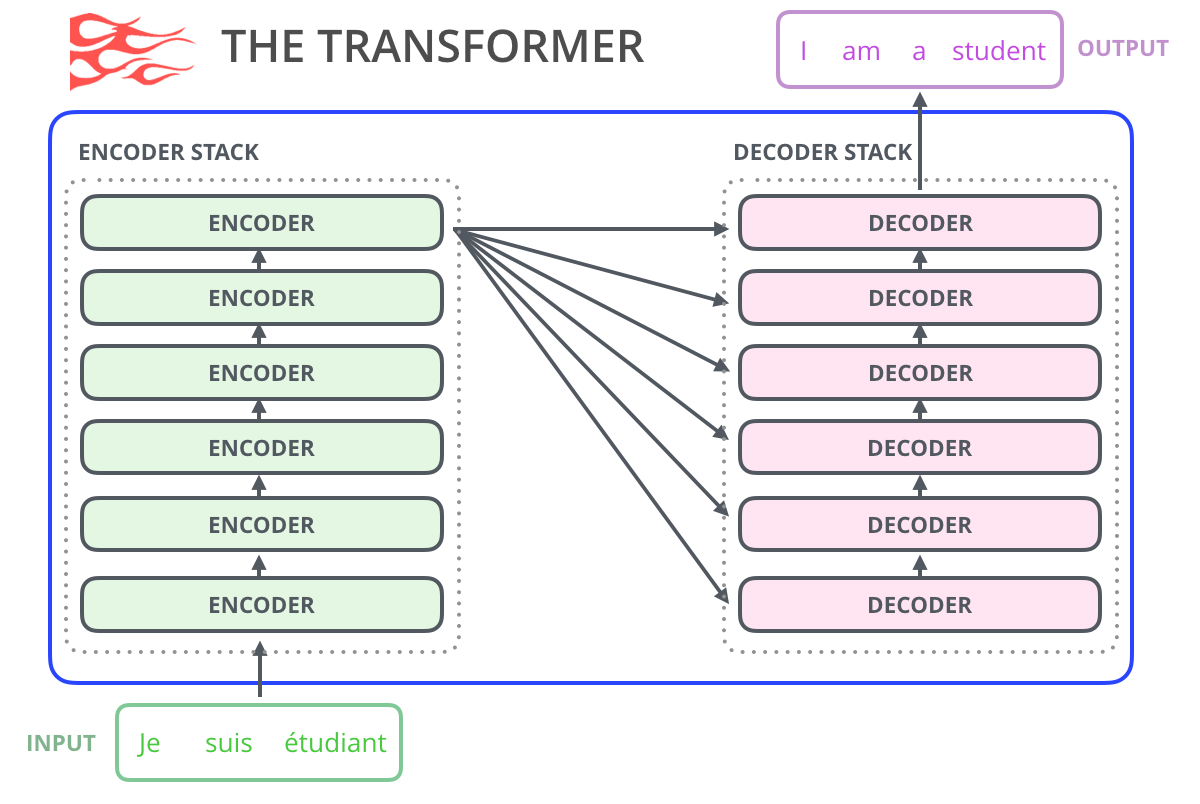

GPT specifically stacks the decoder blocks as high as possible, taking tokens as input

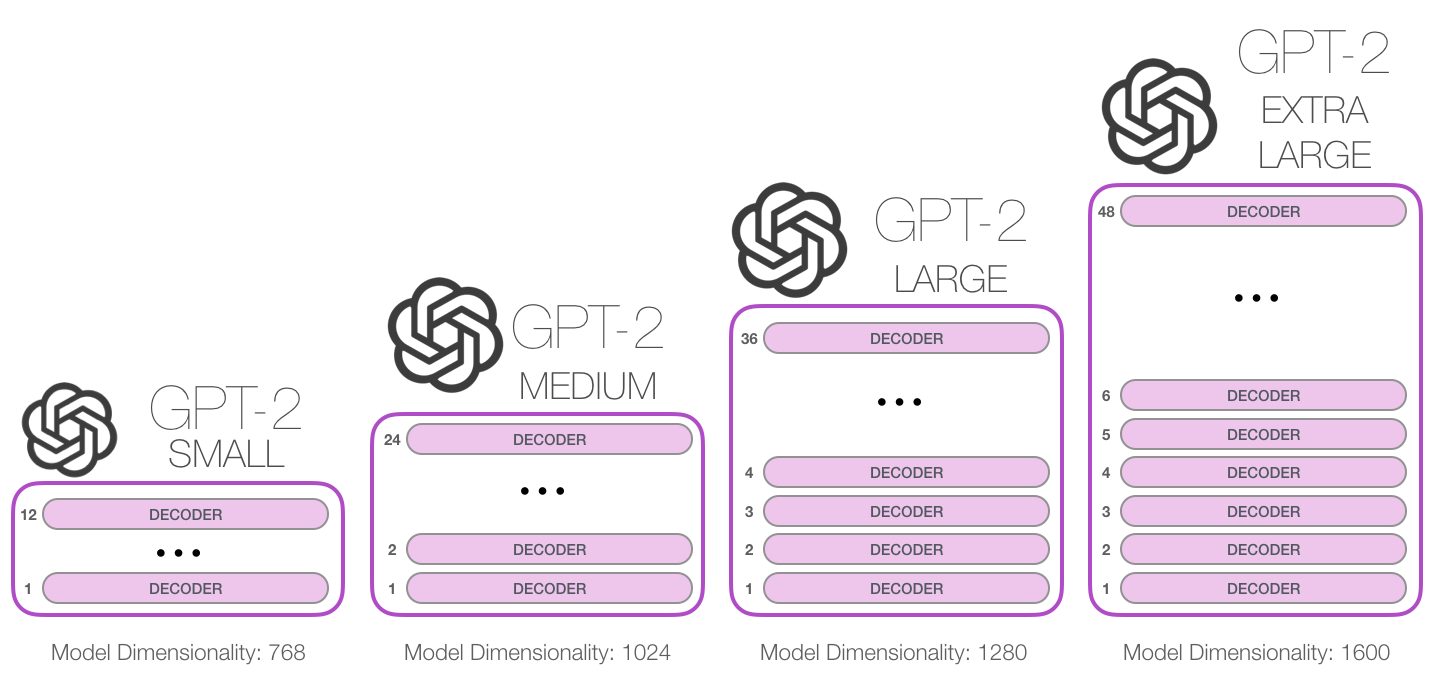

For a deeper dive into the model architecture, take a look at this  article: http://jalammar.github.io/illustrated-gpt2/

# Step 2: Test a Data Science Chatbot using pretrained weights

For this workshop we will funetune Facebook's OPT125M model, a relatively small language model with the same architecture as the BART decoder blocks.

We will load a **pretrained model** and see how it responds to data science questions.

Here is the prompt we will run: `A test statistic is`

In [2]:
from transformers import AutoTokenizer, OPTForCausalLM, pipeline
import torch

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")
model = OPTForCausalLM.from_pretrained("facebook/opt-125m")

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [3]:
pretrained_generator = pipeline(
    'text-generation', model=model, tokenizer='facebook/opt-125m',
    config={'max_length': 200, 'do_sample': True, 'top_p': 0.9, 'temperature': 0.7, 'top_k': 10}
)

In [4]:
# Run cell to see how model responds to prompt
print('----------')
PROMPT='A test statistic is'
print(pretrained_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])

print('----------')
PROMPT='A test statistic is not'
print(pretrained_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])

print('----------')
PROMPT='A test statistic cannot'
print(pretrained_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])

----------
A test statistic is a statistic that is used to determine the number of people who have been diagnosed with
----------
A test statistic is not a statistic. It is a statistic.
I'm not sure what you
----------
A test statistic cannot be used to determine the true value of a given number of points.




We can see the model can somewhat respond, but the response is for the most part not usable and nonsense.

# Step 3: Dive into what model training looks like without Determined
### If a data scientist were to write their own training code, this is what it would look like:

```python

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='./data/PDS2.txt',  # Principles of Data Science - Sinan Ozdemir
    block_size=32  # length of each chunk of text to use as a datapoint
)
config = GPT2Config.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)

train_sampler = RandomSampler(dataset)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
train_dataloader = DataLoader(dataset, collate_fn =data_collator ,sampler=train_sampler, batch_size=train_batch_size)

t_total = len(dataset) // gradient_accumulation_steps * num_train_epochs
# Prepare optimizer and schedule (linear warmup and decay)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

model.resize_token_embeddings(len(tokenizer))
model.zero_grad()
train_iterator = trange(int(num_train_epochs), desc="Epoch", disable=local_rank not in [-1, 0])
set_seed(0)
for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=local_rank not in [-1, 0])
    for step, batch in enumerate(epoch_iterator):
        inputs, labels = (batch, batch) # batch contains a dict of {'labels', 'input_ids' and 'attention_mask'}
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.train()

        outputs = model(inputs, labels=labels)
        loss = outputs[0]  # model outputs are always tuple in transformers (see doc)
        if fp16:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        loss.backward()
```

### Here is what it would look like to do hyperparameter search on the same training code

```python

import numpy as np

def train(lr,m):
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path='./data/PDS2.txt',  # Principles of Data Science - Sinan Ozdemir
        block_size=32  # length of each chunk of text to use as a datapoint
    )
    config = GPT2Config.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token

    model = GPT2LMHeadModel.from_pretrained('gpt2')
    model.to(device)
    train_sampler = RandomSampler(dataset)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    train_dataloader = DataLoader(dataset, collate_fn =data_collator ,sampler=train_sampler, batch_size=train_batch_size)

    t_total = len(dataset) // gradient_accumulation_steps * num_train_epochs

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

    model.resize_token_embeddings(len(tokenizer))
    model.zero_grad()
    train_iterator = trange(int(num_train_epochs), desc="Epoch", disable=local_rank not in [-1, 0])
    set_seed(0)
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            inputs, labels = (batch, batch) # batch contains a dict of {'labels', 'input_ids' and 'attention_mask'}
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.train()

            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)
            if fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            loss.backward()
    model, loss
def hp_grid_search():
    for lr in np.logspace(-4, -2, num=10):
        for m in np.linspace(0.7, 0.95, num=10):
            print(f"Training model with learning rate {lr} and momentum {m}")
            model, loss = train(lr,m)
            print(f"Train Loss: {loss}\n")

try:
    hp_grid_search()
except KeyboardInterrupt:
    pass


```

### What's Missing?
This approach works in theory -- we could get a good model, save it, and use it for predictions. But we're missing a lot from the ideal state:

### Distributed training
    - Parallel search
    - Intelligent checkpointing
    - Interruptibility and fault tolerance
    - Logging of experiment configurations and results

# Step 4: Overview of integrating Pytorch training code into MLDE

Here we will see how to implement the same training loop in MLDE, but automatically enable distributed training, automated checkpointing, and automatic hyperparameter search.

The main components for any deep learning training loop are the following:
* Datasets
* Dataloader
* Model
* Optimizer
* (Optional) Learn rate schedule
* training a batch, evaluating a batch

We will show how to integrate each core part into MLDE using the PyTorchTrial API. Note we have another API called CoreAPI, that supports flexibility if your team wants to integrate more complex Machine Learning codebases. 

### Template Class that integrates DL code with MLDE
The Template class is class we need to fill in to implement our training loop

```python
import filelock
import os
from typing import Any, Dict, Sequence, Tuple, Union, cast

import torch
import torch.nn as nn
from torch import optim
from determined.pytorch import DataLoader, PyTorchTrial, PyTorchTrialContext

import data

TorchData = Union[Dict[str, torch.Tensor], Sequence[torch.Tensor], torch.Tensor]

class OPTFinetuneTrial(PyTorchTrial):
    def __init__(self, context: PyTorchTrialContext) -> None:
        # Trial context contains info about the trial, such as the hyperparameters for training
        self.context = context
        
        # init and wrap model, optimizer, LRscheduler, datasets
       

    def build_training_data_loader(self) -> DataLoader:
        # create train dataloader from dataset
        return DataLoader()

    def build_validation_data_loader(self) -> DataLoader:
        # create train dataloader from dataset
        return DataLoader()

    def train_batch(self, batch: TorchData, epoch_idx: int, batch_idx: int)  -> Dict[str, Any]:
        return {}

    def evaluate_batch(self, batch: TorchData) -> Dict[str, Any]:
        return {}
```

### Wrapping the Model
* Wrapping model to the TrialContext allows MLDE to reduces boilerplate code
* Providing a state-of-the-art training loop that provides distributed training, hyperparameter search, automatic mixed precision, reproducibility, and many more features
* All the models, optimizers, and LR schedulers must be wrapped with wrap_model and wrap_optimizer respectively

```python
self.model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")
# Wrapping model to the TrialContext 
self.model = self.context.wrap_model(self.model)
```

### Wrapping the Optimizer

```python
self.optimizer = self.context.wrap_optimizer(
            AdamW(optimizer_grouped_parameters, lr=self.learning_rate, eps=self.adam_epsilon)
            )
```

### Wrapping the Learn Rate Scheduler

```python
self.scheduler = self.context.wrap_lr_scheduler(
    get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=self.warmup_steps,
                                    num_training_steps=self.t_total),
    LRScheduler.StepMode.MANUAL_STEP
)
```

### Integrating a Dataset
Here we integrate the same TextDataset (used in Step 3) that formats and preprocess our text file to finetune our GPT model on. 

```python
dataset = TextDataset(
                tokenizer=tokenizer,
                file_path='/run/determined/workdir/shared_fs/workshop_data/PDS2.txt',
                block_size=32  # length of each chunk of text to use as a datapoint
            )
```

### Implement Train Dataloader and Validation Dataloader

```python
def build_training_data_loader(self) -> None:
    '''
    '''
    self.train_sampler = RandomSampler(self.dataset)
    self.train_dataloader = DataLoader(self.dataset, collate_fn =self.data_collator ,sampler=self.train_sampler, batch_size=self.train_batch_size)
    return self.train_dataloader
def build_validation_data_loader(self) -> None:
    '''
    '''
    self.eval_sampler = SequentialSampler(self.dataset)
    self.validataion_dataloader = DataLoader(self.dataset,collate_fn =self.data_collator, sampler=self.eval_sampler, batch_size=self.eval_batch_size)
```

### Implement Train Batch and Evaluate Batch

```python
def train_batch(self,batch,epoch_idx, batch_idx):
    '''
    '''
    inputs,labels = self.format_batch(batch)
    outputs = self.model(inputs, labels=labels)
    loss = outputs[0]
    train_result = {
        'loss': loss
    }
    self.context.backward(train_result["loss"])
    self.context.step_optimizer(self.optimizer)
    return train_result

def evaluate_batch(self,batch):
    '''
    '''
    inputs,labels = self.format_batch(batch)
    outputs = self.model(inputs, labels=labels)
    lm_loss = outputs[0]
    eval_loss = lm_loss.mean().item()
    perplexity = torch.exp(torch.tensor(eval_loss))

    results = {
        "eval_loss": eval_loss,
        "perplexity": perplexity
    }
    return results
```

# Step 5: Defining Training Experiment Trial with Model Config
In Determined, a **trial** is a training task that consists of a dataset, a deep learning model, and values for all of the model’s hyperparameters. An **experiment** is a collection of one or more trials: an experiment can either train a single model (with a single trial), or can train multiple models via. a hyperparameter sweep a user-defined hyperparameter space.


Here is what a configuration file looks like for a single trial experiment
```yaml
name: opt125m_finetune
workspace: <your_workspace>
project: <your_project>
description: "OPT125m"
hyperparameters:
    global_batch_size: 4
    weight_decay: 0.0
    learning_rate: 5e-5
    adam_epsilon: 1e-8
    warmup_steps: 0
    epochs: 2
    gradient_accumulation_steps: 1
    dataset_name: 'PDS2'
bind_mounts:
  - container_path: /mnt/efs
    host_path: /mnt/efs
    propagation: rprivate
    read_only: false
environment:
    image: "mendeza/mistral-rag-env:0.0.1"
records_per_epoch: 64
resources:
    slots_per_trial: 1
    resource_pool: compute-pool-a10
min_validation_period:
  batches: 2
profiling:
  begin_on_batch: 0
  enabled: true
min_checkpoint_period:
  batches: 30
searcher:
    name: single
    metric: eval_loss
    max_length:
        epochs: 1
    smaller_is_better: true
max_restarts: 0
entrypoint: python3 -m determined.launch.torch_distributed --trial model_def:OPTFinetuneTrial
```

Here is what a configuration yaml file looks like to do a hyperparameter search
```yaml
name: opt125m_adaptive_finetune
workspace: <your_workspace>
project: <your_project>
description: "OPT125m"
hyperparameters:
    global_batch_size: 32
    weight_decay: 0.0
    learning_rate:
        type: log
        minval: -6.0
        maxval: -4.0
        base: 10.0
    adam_epsilon:
        type: log
        minval: -10.0
        maxval: -8.0
        base: 10.0
    warmup_steps: 0
    epochs: 10
    gradient_accumulation_steps: 1
    dataset_name: 'PDS2'
bind_mounts:
  - container_path: /mnt/efs
    host_path: /mnt/efs
    propagation: rprivate
    read_only: false
environment:
    image: "mendeza/mistral-rag-env:0.0.1"
records_per_epoch: 64 # There are 4696 examples total in the PDS2 dataset, shortening to 147 records per epoch for experimentation
resources:
    slots_per_trial: 2
    resource_pool: compute-pool-a10
min_validation_period:
  batches: 2
profiling:
  begin_on_batch: 0
  enabled: true
min_checkpoint_period:
  batches: 30
searcher:
    name: adaptive_asha
    metric: eval_loss
    max_length:
        epochs: 30
    smaller_is_better: true
    max_trials: 4
max_restarts: 0
entrypoint: python3 -m determined.launch.torch_distributed --trial model_def:OPTFinetuneTrial
```

# Step 6: Updating model configuration files

## Step 6.1: Update `const_ds_chatbot.yaml`
Please  update the `const_ds_chatbot.yaml` file in the `determined_files/` folder and look for the `workspace` and `project` fields. Replace the placeholders with your workspace name and project name, which you created during the preparation session:

```yaml
workspace: <your_workspace>
project: <your_project>
```

# Step 7: Finetuning a Chatbot on a Data Science Textbook
Run cell to start finetuning chatbot on data science book. Note we are taking a **pre-trained model** from Huggingface, and finetuning the model to learn about data science and understand data science concepts. We are not training from scratch.

We have already configured our experiment in `determined_files/const_ds_chatbot.yaml` that trains on a text file called PDS2.txt. This is a text file from a Pakt publishing book called "Principles of Data Science". Link to the book here https://www.packtpub.com/product/principles-of-data-science/9781785887918

In [5]:
# Keep track of the Experiment ID that is in the output of this cell
!det experiment create \
    determined_files/const.yaml \
    determined_files/ 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Preparing files to send to master... 50.1KB and 13 files
Failed to create experiment: invalid experiment configuration: version 0 experiment config is invalid: config is invalid: <config>: additionalProperties "max_length" not allowed


### Step 7.1 See Result
Replace the <EXP_ID> with the experiment ID once the experiment is completed in MLDE. only then they will be able to test their finetuned model on their book

In [17]:
experiment_id = 146
checkpoint = client.get_experiment(experiment_id).top_checkpoint(sort_by="eval_loss", smaller_is_better=True)
print(checkpoint.uuid)
loaded_model = load_model_from_checkpoint(checkpoint)

/tmp/ipykernel_329/3967886187.py:2: FutureWarning: Experiment.top_checkpoint() has been deprecated and will be removed in a future version.Please call Experiment.list_checkpoints(...,max_results=1) instead.
  checkpoint = client.get_experiment(experiment_id).top_checkpoint(sort_by="eval_loss", smaller_is_better=True)


a5a8aea9-70f8-4901-a2bc-e51633e886e3


In [18]:
# This code defines the Huggingface pipeline to load pretrained model and generate responses to a prompt
finetuned_generator = pipeline(
    'text-generation', model=loaded_model, tokenizer=tokenizer,
    config={'max_length': 200,  'do_sample': True, 'top_p': 0.9, 'temperature': 0.7, 'top_k': 10}
)

Here is how the chatbot responds to same prompt after finetuning

In [ ]:
# Run cell to see how model responds to prompt
print('----------')
PROMPT='A test statistic is'
print(finetuned_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])

print('----------')
PROMPT='A test statistic is not'
print(finetuned_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])

print('----------')
PROMPT='A test statistic cannot'
print(finetuned_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])


# Step 8: Launch a distributed training Experiment
With Determined, to scale an experiment/trial to multiple GPUs requires a single configuration line change. There is no need to worry about setting up frameworks like Horovod or PyTorch Distributed Data Parallel (DDP), or Pytorch Lightning.

We have an example of an experiment yaml file that defines training a model with 2 gpus. This yaml is located in the `determined_files/` folder and named `dist_ds_chatbot.yaml`. We can open the file and see the `slots_per_trial` field is set to`2`. `slots_per_trial` defines the number of GPUs you want to use when running a distributed training job. With a single line change, Determined automatically kicks off a Distributed Data Parallel job and configures all the setting needed to run a distributed training job across GPUs.

Lets change the workspace and project settings in the `dist_ds_chatbot.yaml` based on the workspace name and the project name you previously defined.
```yaml
workspace: <your_workspace>
project: <your_project>
```

Running the below cell executes the job. 

In [15]:
# !det experiment create \
#     determined_files/dist.yaml \
#     determined_files/ 

# Step 9: Hyperparameter search
With Determined, to modify an experiment/trial to perform hyperparameter search only requires changing a few lines. There is no need to worry about building hyperparameter search on your own.

We have an example of an experiment yaml file that defines training a model with 2 gpus. This yaml is located in the `determined_files/` folder and named `adaptive.yaml`. We can open the file and see the `hyperparameters` fields have ranges now instead of just values. These ranges are automatically swept across in separate trials when running a training job. With a few changes, Determined automatically kicks off a hyperparameter tuning job and configures all the settings needed.

Lets change the workspace and project settings in the `adaptive.yaml` based on the workspace name and the project name you previously defined.
```yaml
workspace: <your_workspace>
project: <your_project>
```

Running the below cell executes the job. 

In [14]:
# !det experiment create \
#     determined_files/adaptive.yaml \
#     determined_files/ 

# User Exercise 1: Finetune on any huggingface datasets
Lets form into groups, download text from online, and train our own chatbots!

Huggingface contains a ton of available models and datasets to work with! Here's a few examples:
- https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k
- https://huggingface.co/datasets/wikitext
- https://huggingface.co/datasets/Abirate/english_quotes

Steps to integrate custom dataset:
* Go to the dataset page on huggingface and pick one
* copy the huggingface dataset path
* Finally, change `dataset_name` field that describes the name of the experiment
    - example -> `dataset_name: wikiface`

# User Exercise 2: Finetune chat book on and dataset or book from Project Gutenberg
Lets form into groups, download text from online, and train our own chatbot!

Steps to integrate custom dataset:
* Go to project gutenburg and pick a book: (i.e. https://www.gutenberg.org/ebooks/1787 )
* copy URL Plain Text UTF-8 .txt file and download using command: 
    - Example: `wget -O hamlet.txt https://www.gutenberg.org/cache/epub/1787/pg1787.txt`
* move to shared directory: `cp hamlet.txt /run/determined/workdir/shared_fs/exercise/ -v`
* Copy `run_det_ds_chatbot.sh` and rename: 
    - i.e. `cp determined_files/const_ds_chatbot.yaml determined_files/const_hamlet_chatbot.yaml `
* NOTE: Make sure that the file is a .txt file, and that there are no spaces in the name of the text file
* Finally, change `name` field that describes the name of the experiment
    - example -> `name: gpt2_finetune_hamlet_chatbot`
* Change the `dataset_name` to name of text file: (i.e. hamlet)
    - Do not include `.txt` in dataset name

In [ ]:
!wget -O <CHANGE_NAME>.txt <URL_TO_TXT_FILE>

In [ ]:
!cp <CHANGE_NAME>.txt /run/determined/workdir/shared_fs/workshop_data/ -v

In [ ]:
!cp determined_files/const_ds_chatbot.yaml determined_files/const_<CHANGE_NAME>_chatbot.yaml

Edit the following fields in `const_<CHANGE_NAME>_chatbot.yaml`
```yaml
name: <CHANGE_EXPERIMENT_NAME>
workspace: <your_workspace>
project: <your_project>
description: "DS Workshop"
hyperparameters:
    global_batch_size: 32
    weight_decay: 0.0
    learning_rate: 5e-5
    adam_epsilon: 1e-8
    warmup_steps: 0
    epochs: 10
    device: 'cuda'
    gradient_accumulation_steps: 1
    dataset_name: <DATASET_NAME_TO_NEW_NAME>
    train_batch_size: 32
    eval_batch_size: 32
environment:
    image: "mendeza/mistral-rag-env:0.0.1"
records_per_epoch: 147 # There are 4696 examples total in the PDS2 dataset, shortening to 147 records per epoch for experimentation
resources:
    slots_per_trial: 1
min_validation_period:
  batches: 4
min_checkpoint_period:
  batches: 147
searcher:
    name: single
    metric: eval_loss
    max_length:
        epochs: 30
    smaller_is_better: true
max_restarts: 0
entrypoint: model_def:GPT2Finetune
```

In [ ]:
# Run finetuning job 
!det experiment create determined_files/const_<CHANGE_ME>_chatbot.yaml determined_files/

Replace the experiment ID with their ID once the experiment is completed in MLDE. only then they will be able to test their finetuned model on their book

In [ ]:
# Run inference
experiment_id = 129
checkpoint = client.get_experiment(experiment_id).top_checkpoint(sort_by="eval_loss", smaller_is_better=True)
print(checkpoint.uuid)
loaded_model = load_model_from_checkpoint(checkpoint)

In [ ]:
finetuned_generator = pipeline(
    'text-generation', model=loaded_model, tokenizer='facebook/opt-125m',
    config={'max_length': 200, 'do_sample': True, 'top_p': 0.9, 'temperature': 0.7, 'top_k': 10}
)

In [ ]:
# Run cell to see how model responds to prompt
print('----------')
PROMPT='A test statistic is'
print(finetuned_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])

print('----------')
PROMPT='A test statistic is not'
print(finetuned_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])

print('----------')
PROMPT='A test statistic cannot'
print(finetuned_generator(PROMPT, num_return_sequences=1)[0]['generated_text'])
